In [1]:
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


rows,cols=(224,224)


#图像加载以及预处理
image_path="picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (rows,cols))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))


torch.Size([1, 3, 224, 224])
label=388


In [3]:
def infer_img(img,t=0):
    
    img=img.astype(np.float32)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img /= 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)

    img=np.expand_dims(img, axis=0)

    img = Variable(torch.from_numpy(img).to(device).float())
    #print(img.shape)

    #使用预测模式 主要影响droupout和BN层的行为
    model = models.alexnet(pretrained=True).to(device).eval()
    
    
    output=F.softmax(model(img),dim=1)
        
    label=np.argmax(output.data.cpu().numpy())
    #print("label={}".format(label))
    
    pro=output.data.cpu().numpy()[0][label]
    
    #当t不为0时返回指定类别的概率
    if t != 0:
        pro=output.data.cpu().numpy()[0][t]
        
    
    #print("{}={}".format(t,pro))
    return pro

In [4]:
print(infer_img(orig))
print(infer_img(orig,t=288))
print(infer_img(orig,t=388))

0.92705107
3.1764077e-06
0.92705107


rotate=0 pro[388]=0.9270510673522949
rotate=10 pro[388]=0.8774341940879822
rotate=20 pro[388]=0.7659609913825989
rotate=30 pro[388]=0.9028661847114563
rotate=40 pro[388]=0.8249250054359436
rotate=50 pro[388]=0.776583194732666
rotate=60 pro[388]=0.5197058320045471
rotate=70 pro[388]=0.38362666964530945
rotate=80 pro[388]=0.22950592637062073
rotate=90 pro[388]=0.6676880121231079
rotate=100 pro[388]=0.548632800579071
rotate=110 pro[388]=0.5739181041717529
rotate=120 pro[388]=0.12950590252876282
rotate=130 pro[388]=0.2069293111562729
rotate=140 pro[388]=0.05994891747832298
rotate=150 pro[388]=0.055233459919691086
rotate=160 pro[388]=0.15117953717708588
rotate=170 pro[388]=0.07836923748254776


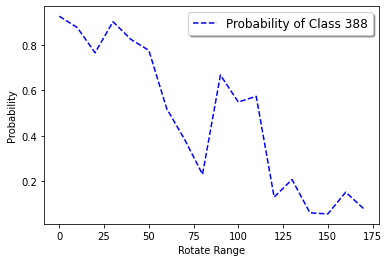

In [5]:
#验证原始图片的旋转不变性
rotate_range = range(0,180,10)
original_pro = []

for i in rotate_range:
    
    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),i,1)
    rotate_img = cv2.warpAffine(orig.copy(),matrix,(cols,rows))
    pro=infer_img(rotate_img.copy(),388)
    print("rotate={} pro[388]={}".format(i,pro))
    original_pro += [pro]

fig, ax = plt.subplots()
ax.plot(np.array(rotate_range), np.array(original_pro), 'b--', label='Probability of Class 388')
#ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Rotate Range')
plt.ylabel('Probability')
plt.show()

In [6]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100
e=0.007

target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())

for epoch in range(epochs):
    
    # forward + backward
    #output = model(img)
    output = F.softmax(model(img),dim=1)

    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())
    pro=output.data.cpu().numpy()[0][label]
    
    print("epoch={} loss={} label={} pro={}".format(epoch,loss,label,pro))
    
    #如果定向攻击成功 并且概率大于阈值
    if (label == target) and ( pro > 0.80):
        print("")
        break
         
    #梯度清零
    optimizer.zero_grad()
    #反向传递 计算梯度   
    loss.backward()
    
    img.data=img.data-e*torch.sign(img.grad.data)


epoch=0 loss=6.909350872039795 label=388 pro=0.9270510673522949
epoch=1 loss=6.908727645874023 label=388 pro=0.13727833330631256
epoch=2 loss=6.907970905303955 label=387 pro=0.08647046983242035
epoch=3 loss=6.899903297424316 label=219 pro=0.05867677181959152
epoch=4 loss=6.813358783721924 label=293 pro=0.09739573299884796
epoch=5 loss=6.60948371887207 label=288 pro=0.2993808686733246
epoch=6 loss=6.450402736663818 label=288 pro=0.4584883451461792
epoch=7 loss=6.361993789672852 label=288 pro=0.5469864010810852
epoch=8 loss=6.124091625213623 label=288 pro=0.7850754261016846
epoch=9 loss=6.025216579437256 label=288 pro=0.8840774893760681



/home/miles/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [1, 3, 224, 224], strides() = [3, 1, 672, 3]
param.sizes() = [1, 3, 224, 224], strides() = [150528, 1, 672, 3] (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/autograd/functions/accumulate_grad.h:192.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


In [7]:
#把对抗样本转换成正常图片
adv=img.data.cpu().numpy()[0]
print(adv.shape)

adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

print(adv.shape)

(3, 224, 224)
(224, 224, 3)


(224, 224, 3)


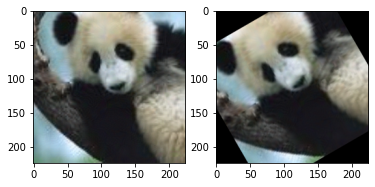

In [8]:
# 得到变换的矩阵，通过这个矩阵再利用warpAffine来进行变换
# 第一个参数就是旋转中心，元组的形式，这里设置成相片中心
# 第二个参数90，是旋转的角度
# 第三个参数1，表示放缩的系数，1表示保持原图大小
matrix = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
img2 = cv2.warpAffine(adv,matrix,(cols,rows))

print(img2.shape)


plt.subplot(121)
plt.imshow(adv) 

plt.subplot(122)
plt.imshow(img2) 


plt.show() 

rotate=0 pro[388]=2.3634725948795676e-05 pro[288]=0.875653862953186
rotate=10 pro[388]=0.755500316619873 pro[288]=6.677052442682907e-05
rotate=20 pro[388]=0.8096970319747925 pro[288]=2.1371577531681396e-05
rotate=30 pro[388]=0.9136471152305603 pro[288]=2.038896309386473e-05
rotate=40 pro[388]=0.8106085062026978 pro[288]=2.9545406505349092e-05
rotate=50 pro[388]=0.867012083530426 pro[288]=1.0508813829801511e-05
rotate=60 pro[388]=0.803071916103363 pro[288]=1.5194282241282053e-05
rotate=70 pro[388]=0.5278446078300476 pro[288]=2.789969767036382e-05
rotate=80 pro[388]=0.39845624566078186 pro[288]=0.0001322960015386343
rotate=90 pro[388]=0.7018682956695557 pro[288]=0.0017089637694880366
rotate=100 pro[388]=0.6548632979393005 pro[288]=0.0001484035892644897
rotate=110 pro[388]=0.6363303661346436 pro[288]=0.0003370266640558839
rotate=120 pro[388]=0.2582848072052002 pro[288]=0.0003079573798459023
rotate=130 pro[388]=0.43168503046035767 pro[288]=0.0001479571219533682
rotate=140 pro[388]=0.157865

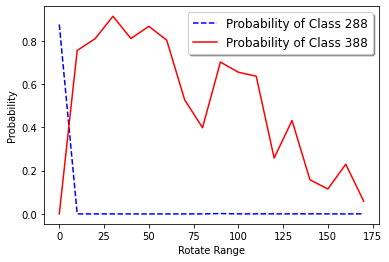

In [9]:
#验证旋转对 对抗样本的影响
rotate_range = range(0,180,10)
adv_288_pro = []
adv_388_pro = []

for i in rotate_range:
    
    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),i,1)
    rotate_img = cv2.warpAffine(adv.copy(),matrix,(cols,rows))
    pro_388=infer_img(rotate_img.copy(),388)
    pro_288=infer_img(rotate_img.copy(),288)
    print("rotate={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(rotate_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(rotate_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Rotate Range')
plt.ylabel('Probability')
plt.show()

rotate=0 adv_pro[388]=2.3634725948795676e-05 original_pro[388]=0.9270510673522949
rotate=10 adv_pro[388]=0.755500316619873 original_pro[388]=0.8774341940879822
rotate=20 adv_pro[388]=0.8096970319747925 original_pro[388]=0.7659609913825989
rotate=30 adv_pro[388]=0.9136471152305603 original_pro[388]=0.9028661847114563
rotate=40 adv_pro[388]=0.8106085062026978 original_pro[388]=0.8249250054359436
rotate=50 adv_pro[388]=0.867012083530426 original_pro[388]=0.776583194732666
rotate=60 adv_pro[388]=0.803071916103363 original_pro[388]=0.5197058320045471
rotate=70 adv_pro[388]=0.5278446078300476 original_pro[388]=0.38362666964530945
rotate=80 adv_pro[388]=0.39845624566078186 original_pro[388]=0.22950592637062073
rotate=90 adv_pro[388]=0.7018682956695557 original_pro[388]=0.6676880121231079
rotate=100 adv_pro[388]=0.6548632979393005 original_pro[388]=0.548632800579071
rotate=110 adv_pro[388]=0.6363303661346436 original_pro[388]=0.5739181041717529
rotate=120 adv_pro[388]=0.2582848072052002 origin

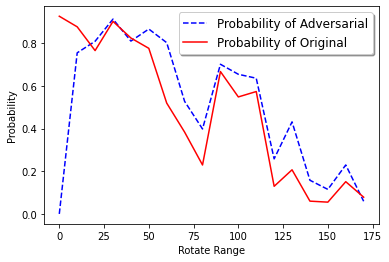

In [10]:
#综合分析验证旋转对 对抗样本和正常图片分类的影响
rotate_range = range(0,180,10)
original_pro = []
adv_pro = []

for i in rotate_range:
    
    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),i,1)
    
    rotate_adv_img = cv2.warpAffine(adv.copy(),matrix,(cols,rows))
    pro_388=infer_img(rotate_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    rotate_img = cv2.warpAffine(orig.copy(),matrix,(cols,rows))
    pro=infer_img(rotate_img.copy(),388)
    original_pro += [pro]
            
    print("rotate={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(rotate_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(rotate_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Rotate Range')
plt.ylabel('Probability')
plt.show()